# Classification of cardiomyocites based on their action potentials
In this lab experience we will be looking at the problem of classifying cardiac cells by looking at
their _Action Potentials_ (APs). For the purpose of this task we will be using synthetically
generated APs following the models in [(Nygren et. al, 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et. al, 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).

### Objectives
By the end of this session you should be able to use nearest-neighbor and simple neural network classifiers for two-class classification problems.

* _Note: Everything below this line should be truned in as part of your lab report._


In [0]:
# ============================================================================
# Casey Weiner
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd
import torch

# inline plots
%matplotlib inline

# set random number generator seed
rnd.seed(10)

# mount GDrive
from google.colab import drive
drive.mount('gdrive/')

# ============================================================================
# data loading
# ============================================================================

# PLEASE, SPECIFY YOUR PATH TO THE DATA HERE
datapath = 'gdrive/My Drive/bmdslab/lab-02/'

# get the list of files to process
matfile = '/'.join((datapath,'Adult_samples.mat'))

# get data as dictionary
adata = scipy.io.loadmat(matfile)

# see the keys of the dictionary 'Vatrial' and 'Vventricular'
# adata['Vatrial'] contains action potentials of cardiac cells of atrial type
# adata['Vventricular'] contains action potentials of cardiac cells of ventricular type
adata.keys()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive/


dict_keys(['__header__', '__version__', '__globals__', 'Vatrial', 'Vventricular'])

Text(0.5, 0, 'sample')

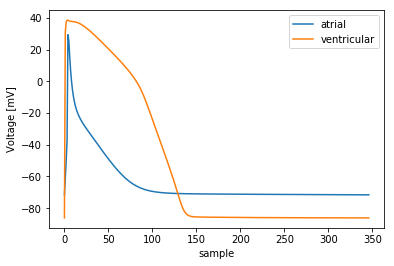

In [0]:
# look at the data dimensions
adata['Vatrial'].shape

# let's see how the data looks like
plt.plot(adata['Vatrial'][:,0])
plt.plot(adata['Vventricular'][:,0])
plt.legend(('atrial','ventricular'))
plt.ylabel('Voltage [mV]')
plt.xlabel('sample')

### Task 1. Pre-processing and manual feature extraction
In this first part we will be normalizing the data and extracting hand-crafted features that will be later
used for the classification task. Load the dataset **Adult_samples.mat** that contains examples of
adult atrial and ventricular action potentials generated using the models in [(Nygren et al., 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et al., 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).
For each of the two classes there are $1000$ samples generated with a sampling rate of $f_s=500$ Hz.

* _(15 points) Data preparation and normalization._
Split the data between test and training sets by
randomly selecting $10\%$ of the points as your training set. Make sure the two classes are well represented
in the training set (e.g., use the same number for both). Normalize the data so that each AP has zero resting potential and unit maximum amplitude. Create an array of corresponding labels for the data points. For ventricular type use the class label $+1$ and $-1$ for
atrial type.
Make two plots displaying your normalized training data for each of the classes. Use time units for the horizontal axis.

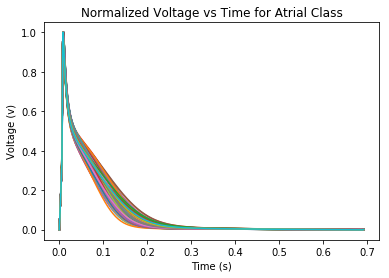

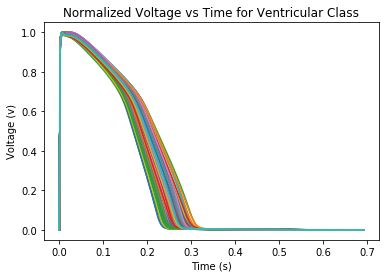

In [0]:
# Load data as numpy array
va = adata['Vatrial']
vv = adata['Vventricular']

#Subtract Min so lowest value is zero
va = va - va[-1,:]
vv = vv - vv[-1,:]

#Divide by max so max amplitude is 1
va_max = np.max(va,axis = 0)
vv_max = np.max(vv,axis = 0)
va = va / va_max
vv = vv / vv_max

#Random sample of 100 points from data set
#Construct loop to get 100 random columns from each numpy array
trainFraction = 0.10
array = np.zeros(1000, dtype=bool)
length_of = int(trainFraction * len(va[0]))
used = []
count = 0 #Count keeps track of how many random indices have been set to true.
while count < length_of: 
  boolean = True
  #Wile loop is used so that random indices can continually be picked and tested.
  while boolean:
    index = np.random.randint(1000) #Finds a random index between 0 and 999 inclusive.
    if index not in used: #If the index has not been used before then assign True to that index.
      array[index] = True
      used.append(index) #Add the index to used list so that it cannot be written over again and double counted.
      boolean = False
      
  count += 1

  
#Plugging in conditionals to numpy array
vs_train = va[:,array] #Training data for atrial
vv_train = vv[:,array] #Training data for ventricular
va_test = va[:,~array] #Testing data for atrial
vv_test = vv[:,~array] #Testing data for atrial

#Combining the data matrices by column
training = np.hstack((va_train,vv_train))
testing = np.hstack((va,vv))  

#Creating x-axis values, in units of time
xaxislist = range(0,347)
xaxis = [x / 500 for x in xaxislist]

#Two plots for each of the classes
plt.figure()
plt.plot(xaxis,va_train)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (v)')
plt.title('Normalized Voltage vs Time for Atrial Class')

plt.figure()
plt.plot(xaxis,vv_train)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (v)')
plt.title('Normalized Voltage vs Time for Ventricular Class')

#Creating labels list for training data
classlabel_n = list([-1] * 100)
classlabel_p = list([1] * 100)
labels = classlabel_n + classlabel_p

* _(20 points) Hand-crafted features._
The _Action Potential Duration_ (APD) at $x\%$ is defined as the time
it takes to reduce the maximum amplitude of the AP to $x\%$ of its value. Write a function that computes APD at a given
percentage $x\in[0,1]$. Compute also the _Average of the Action Potential_ (AAP) and build two-dimensional features
by concatenating APD@$0.5$ and AAP. Make a scatter plot of the training data using these two features. Use
different colors and/or markers to represent each class.

    * Based on your scatter plot, is the training data using the above features linearly separable? Why?

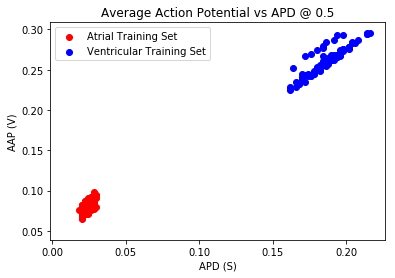

In [0]:
# ============================================================================
# compute hand-crafted features such as APA and APDx
# ============================================================================

def apdx(X,alpha=0.5,fs=1.0):
    """
    This function computes the APDx feature defined as the time it takes to
    reduce the action potential to x% of its maximum value.
    Use:
        APD = apdx(X,alpha,fs)
        
    Inputs:
        X : data points (each column is a data point)
        alpha : [0,1] percentage of maximum amplitude
        fs : sampling frequency (to map samples to time)
        
    Output:
        APD feature
    """

    # write your function code here
    m = np.argmax(X, axis = 0)
    maxdata = np.max(X, axis = 0)
    list = []
    for i in range(len(X[0])):
      now = m[i] #Index of the max of the current column
      allval = X[range(now, 347),i] #List of all values in column after max
      thresh = maxdata[i] * alpha #Multiplies max of current column by the percentage
      allsub = np.abs(allval - thresh) #Takes the absolute value and finds min so index of closest value is found.
      mindata = np.argmin(allsub) #This is the distance to percentage index from max index because allval starts at index of max.
      list.append((mindata)/fs) #Converts distance to time units
    return list
  
#Calculate AAP and APDx for the training set and entire set
avg_at = np.mean(va_train, axis=0)
avg_vt = np.mean(vv_train, axis=0)
avg_a= np.mean(va, axis=0)
avg_v = np.mean(vv, axis=0)
apdvat = apdx(va_train, alpha = 0.5, fs = 500.0)
apdvvt = apdx(vv_train, alpha = 0.5, fs = 500.0)  
apdva = apdx(va, alpha = 0.5, fs = 500.0)
apdvv = apdx(vv, alpha = 0.5, fs = 500.0)

#Combine classes into training set and entire set
xtrain = np.hstack((apdvat,apdvvt))
avgtrain = np.hstack((avg_at, avg_vt))
xrtrain = np.vstack((xtrain, avgtrain))
xa = np.hstack((apdva,apdvv))
avgav = np.hstack((avg_a,avg_v))
xr = np.vstack((xa, avgav))

#Plotting all with different colors 
plt.scatter(xrtrain[0,range(100)], xrtrain[1,range(100)], c= 'r')
plt.scatter(xrtrain[0,range(100,200)], xrtrain[1,range(100,200)], c= 'b')
plt.title('Average Action Potential vs APD @ 0.5')
plt.xlabel('APD (S)')
plt.ylabel('AAP (V)')
plt.legend(['Atrial Training Set','Ventricular Training Set'])         
    
# The training data is linearly separable since there exists a line which
# can separate the data


### Task 2. Classification

* _(15 points) Nearest-neighbor classifier._
Implement a $1$NN classifier using the Euclidean distance. A $1$NN classifier works as follows: Given your training dataset $\mathcal{D} = \big\{(\boldsymbol x_i,y_i)\big\}_{i=1}^{N}$,where $N$ is the number of training samples, $\boldsymbol x_i\in\mathbb{R}^D$ is a feature vector and $y_i\in\{-1,1\}$ its associated label, and a novel sample $\boldsymbol x$, the $1$NN classifier assigns to $\boldsymbol x$ the same label as its closest point in the training set. That is, the estimated label $\widehat y$ of $\boldsymbol x$ is such that:

\begin{equation}
	\widehat y(\boldsymbol x) = y_{k^*},\quad k^* = \underset{i\in\{1,\ldots,N\}}{\arg\min}\, \lVert \boldsymbol x_i - \boldsymbol x \rVert_2.
\end{equation}

Compute and display the classification accuracy over the test set using the handcrafted training features of **Task 1**.

In [0]:
# ============================================================================
# Nearest-neighbor classifier
# ============================================================================

def nn_classify(Xtest,Xtrain,ytrain):
    """
    This function implements a nearest neighbor classifier.
    Use:
        yhat = nn_classify(Xtest,Xtrain,ytrain)
        
    Inputs:
        Xtest  : test data points (each column is a data point)
        Xtrain : training data points
        ytrain : associated labels to the training data points
        
    Output:
        yhat : estimated labels for the test data.

    """
    
    # implement your NN classifier below
    # ...
    yhat = []
    k = [0] * len(Xtrain[0])
    yhat = [0] * len(Xtest[0])
    for i in range(len(Xtest[0])):
      for j in range(len(Xtrain[0])):
        k[j] = np.linalg.norm(Xtest[:,i] - Xtrain[:,j]) #Norm is found from subtracting each column of training from one column of test. 
      index_of_min = np.argmin(k) #Min norm found
      yhat[i] = ytrain[index_of_min] #Label of the column that makes min norm is added to yhat vector
      
    return yhat

test = []
#Create training label vector
for i in range(len(va[0])):
  test.append(-1)
for i in range(len(vv[0])):
  test.append(1)
  

final = nn_classify(xr,xrtrain,labels)

#Counting up indices where values are equal 
accuracy = np.sum(np.equal(final,test))/len(test)
print('Classification accuracy is ', accuracy)
    

Classification accuracy is  1.0


* _(40 points) Two-layer Neural Network._
 Implement a two-layer neural network classifier of the form:

   $$\widehat y = \operatorname{sign}\big(f_{\theta}(\phi(\boldsymbol x))\big),\quad f_{\theta}(\phi(\boldsymbol x)) = \boldsymbol w^T\phi(\boldsymbol x) + b,\quad \theta = \left[\begin{array}{c}\boldsymbol w\\b\end{array}\right],$$
  
 where $f_\theta(\cdot)$ is a _linear prediction function_ (i.e., classification layer) parametrized by $\theta = [\boldsymbol w^T, b]^T$. The feature extraction part of the network consists of a linear layer followed by a ReLu (rectified linear unit) non-linearity:
 
 $$ \phi(x) = \operatorname{ReLu}\big(\boldsymbol W_1 \boldsymbol x + \boldsymbol b_1\big),\quad\operatorname{ReLu}(x)=\begin{cases}x &x>0\\0&\textrm{else}\end{cases}.$$
 
 In order to find the network's parameters $\Theta=\{\boldsymbol W_1, \boldsymbol b_1, \boldsymbol w, b\}$ minimize the following _regularized empirical risk_ using PyTorch:

   $$\min_{\Theta}\, \underbrace{\frac{1}{N} \sum_{i=1}^N L\big(f_\theta(\phi(\boldsymbol x_i)),y_i\big) + \lambda\big(\frac{1}{w}\lVert \boldsymbol w\rVert^2 + \frac{1}{W}\lVert\boldsymbol W_1\rVert^2\big)}_{C(\Theta)}$$
    
 where the loss function $L(f, y) = \lVert y-f\rVert_2^2)$ is the quadratic (square) loss, and $w,W$, are the number of elements in $\boldsymbol w$ and $\boldsymbol W$, respectively. 

    * Define a network model in PyTorch according to the definition above. For that purpose you can use `torch.nn.Sequential`. Follow this [example](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-nn) to learn how to use it.
    
    * Run a gradient descent algorithm to minimize the cost function using $\lambda =1$. Carefully choose the stepsize and number of iterations until you see the method converges (i.e., the cost function gets to a "plateau").
    
    * Make a scatter plot of the learned features (i.e., prior to classificaiton layer) by your network model. Has your model learned features that are linearly separable? Display in the scatter plot the decision boundary that you have learned. Compute the classification accuracy over the test set.
    
    * Plot the weights of the learned linear layer. What has your network learned?



99 0.6217793822288513
199 0.37393301725387573
299 0.268798291683197
399 0.21704356372356415
499 0.18690258264541626


Text(0, 0.5, 'Cost')

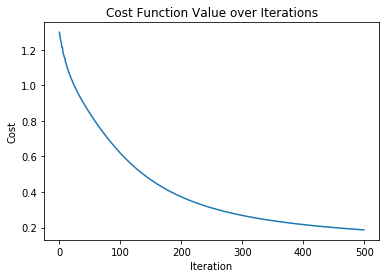

In [0]:
import torch

torch.manual_seed(0)
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 347, 2, 1

# Create random Tensors to hold inputs and outputs
x = torch.from_numpy(np.transpose(training)).float()
y = torch.from_numpy(np.asarray(labels)).float()

# We defined these variables at the beginning to save time and 
# allow for changes to be made to these with ease.
W = torch.nn.Linear(D_in, H,bias =True)
f = torch.nn.ReLU()
w = torch.nn.Linear(H, D_out,bias =True)

model = torch.nn.Sequential(
    W,
    f,
    w
)

# Loss function is mean-square error:
loss_fn = torch.nn.MSELoss(reduction='mean')
losses = []

learning_rate = 1e-2
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)
    w = model[0]
    W = model[2]
    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    lam = 1
    loss = loss_fn(torch.squeeze(y_pred), y) + lam*(W.weight.pow(2).mean()+w.weight.pow(2).mean())

    losses.append(loss.item())
    
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
   
  
#Plotting the plateau
plt.plot(losses)

plt.title('Cost Function Value over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')

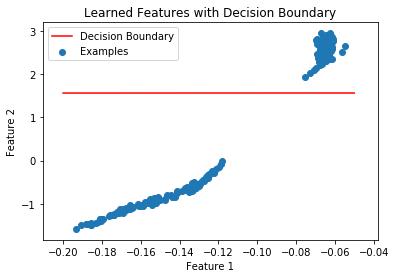

In [0]:
#Scatterplot of the learned features 
w1 = model[0].weight.detach().numpy();
w2 = model[2].weight.detach().numpy();
learned_f= w @ training
bias = model[0].bias.detach()
a = np.asarray(model[2].weight.detach())
b = np.asarray(model[2].bias.detach())
x = np.linspace(-.2, -0.05, num=2)
y = ((-1 * x * a[:, 0]) - b) / a[:, 1]
plt.figure()
plt.scatter(learned_f[0,:], learned_f[1,:])
plt.plot(x, y, 'r')
plt.title('Learned Features with Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(['Decision Boundary', 'Examples'])

In [0]:
# Compute classification accuracy on test data
y = model(torch.from_numpy(np.transpose(testing)).float())
accuracy_ = 0
for i in range(len(y)):
  if y[i] > 0:
    if test[i] == 1:
      accuracy_ += 1
  else:
    if test[i] == -1:
      accuracy_ += 1
accuracy_ /= len(test)
print('Classification Accuracy: ')
print(accuracy_)

Classification Accuracy: 
1.0


Text(0, 0.5, 'Weights')

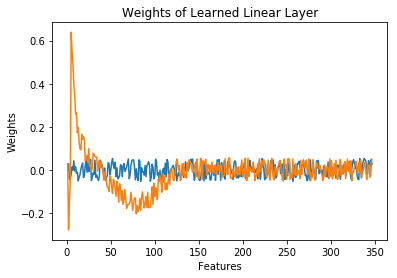

In [0]:
#Plotting Weights of Learned Layer
plt.figure()
w0 = model[0].weight[0,:].detach().numpy()
w1 = model[0].weight[1,:].detach().numpy()
plt.plot(np.linspace(1, 347, num=347), w0)
plt.plot(np.linspace(1, 347, num=347), w1)
plt.title('Weights of Learned Linear Layer')
plt.xlabel('Features')
plt.ylabel('Weights')